In [23]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

True

In [19]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [69]:
# SQL query
# After running the query and reviewing the chart, it was determined that
# the store_temperature values are too finely grained (e.g. 7.46, 12.19, 14.02, etc)
# This is creating a bar in the bar chart for each individual value.  The 
# result is that we have created hundreds of bars to represent each individual
# value.  Visually, the bars are too thin to be seen and are of no use.
# Fractional variance in degrees are negligible (i.e. the difference between
# 7.42 degrees and 7.65 degrees is insignificant at this level).  To see 
# measurable and visual bars for the report, round the store_temperature to
# the nearest whole number.
# UPDATE: Tried the above approach and the temperatures are still too finely granulated.
# Group the temperatures into "bins" where we truncate the temperature to the nearest
# multiple of 5.
sql = """
SELECT 
  FLOOR(f.store_temperature / 5) * 5 AS store_temperature,
  d.store_date,
  AVG(f.store_weekly_sales) AS weekly_sales,
  SUM(f.store_weekly_sales) AS total_weekly_sales
FROM 
  walmart_fact_table f
LEFT JOIN
  walmart_date_dim d
ON
  f.date_id = d.date_id
WHERE
  f.store_temperature IS NOT NULL
AND
  f.store_temperature >= 0
GROUP BY 1,2
ORDER BY 1,2
"""

# Run query using Snowflake connector
cur = conn.cursor()
cur.execute(sql)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force column names to lowercase so Snowflake will match the model table
df.columns = [col.lower() for col in df.columns]

# print(df.columns)
df['year'] = pd.to_datetime(df['store_date']).dt.year

# Convert the temperature bins to string representations to help
# plotly create a more managable range for the y-axis.  However,
# let's sort the temperatures to ensure they remain in the correct order.
df.sort_values(by='store_temperature', inplace=True)
df['store_temperature_bin'] = df['store_temperature'].astype(str)


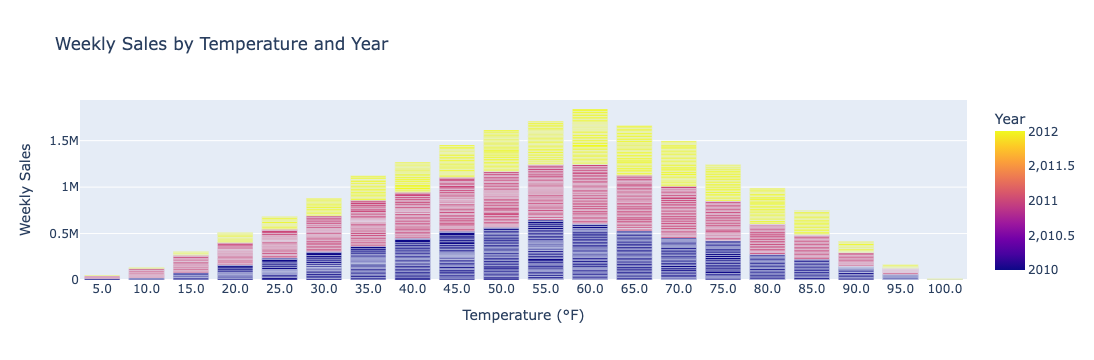

In [70]:
# Plot using Plotly
fig = px.bar(
    df,
    x='store_temperature_bin',
    y='weekly_sales',
    color='year',
    barmode='stack',
    title='Weekly Sales by Temperature and Year',
    labels={
        'store_temperature_bin': 'Temperature (°F)',
        'weekly_sales': 'Weekly Sales',
        'year': 'Year'
    }
)

fig.show()

In [12]:
df_min_date = pd.read_sql('SELECT MIN(store_date) FROM walmart_date_dim', conn)
earliest_date = df_min_date.iloc[0,0]
weekdayname = earliest_date.strftime('%A')
monthname = earliest_date.strftime('%B')

print(f"{weekdayname}, {monthname} {earliest_date.day}, {earliest_date.year}\nEarliest Date")


Friday, February 5, 2010
Earliest Date


/var/folders/90/m9dcfcxn38j0ypf7wjqn_bf80000gp/T/ipykernel_9892/745611481.py:1: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [13]:
median_temp = df['store_temperature'].median()
avg_temp = df['store_temperature'].mean()

print(f"The median temperature was {median_temp}")
print(f"The average temperature was {avg_temp:.2f}°F")

The median temperature was 55.0
The average temperature was 54.83°F


In [17]:
total_sales = df['total_weekly_sales'].sum()
print(f"Total Weekly Sales: {total_sales / 1e9:.2f} bn")

Total Weekly Sales: 6.74 bn


/var/folders/90/m9dcfcxn38j0ypf7wjqn_bf80000gp/T/ipykernel_9892/2485916046.py:28: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



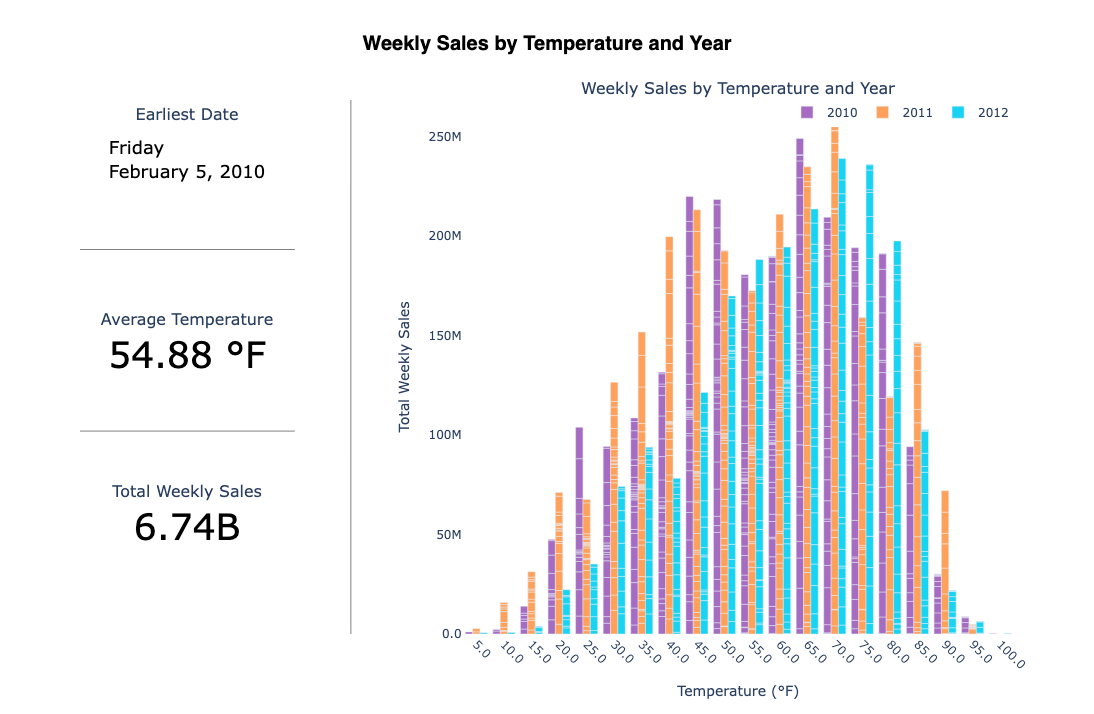

In [79]:
# Let's combine the graph and the summary table into a single dashboard-style presentation

# First, set up the overall container for the charts.  Here, we have a 3-row, 2-column
# layout where row1,col2 spans 3 rows
fig = make_subplots(
    rows=3,
    cols=2,
    specs=[
        [{'type':"indicator", 't':0, 'b':0}, {"type": "xy", "rowspan": 3}],
        [{"type": "indicator", 't':0}, None],
        [{"type": "indicator", 't':-0.06}, None]
    ],
    column_widths=[0.28, 0.72],
    row_heights=[0.33, 0.33, 0.33],
    horizontal_spacing=0.18,
    vertical_spacing=0.15,
    subplot_titles=(
        "",
        "Weekly Sales by Temperature and Year",
        "",
        ""
    )
)

# ========================================

# First, let's add the earliest date indicator in row1, col1
df_min_date = pd.read_sql('SELECT MIN(store_date) FROM walmart_date_dim', conn)
earliest_date = df_min_date.iloc[0,0]
weekdayname = earliest_date.strftime('%A')
monthname = earliest_date.strftime('%B')
formatted_date = f"{weekdayname}<br>{monthname} {earliest_date.day}, {earliest_date.year}"

earliest_date_indicator = go.Table(
    header = dict(
        values = ["Earliest Date"],
        fill_color = 'white',
        align = 'center',
        font = dict(size=16)
    ),
    cells = dict(
        values = [[formatted_date]],
        align = 'center',
        fill_color = 'white',
        font = dict(size=18, color='black')
    )
)

fig.add_trace(earliest_date_indicator, row=1, col=1)

# ========================================

# Next, let's add the average/mean indicator in row2, col1
median_temp = df['store_temperature'].median()
avg_temp = df['store_temperature'].mean()

average_temp_indicator = go.Table(
    header = dict(
        values = ["Average Temperature"],
        fill_color = 'white',
        align = 'center',
        font = dict(size=16)
    ),
    cells = dict(
        values = [[f"{avg_temp:.2f} °F"]],
        align = 'center',
        fill_color = 'white',
        font = dict(size=36, color='black')
    )
)

fig.add_trace(average_temp_indicator, row=2, col=1)

# ========================================

# Next, add the total weekly sales indicator, row3, col1
def formatTotalSales(value):
    if value >= 1_000_000_000:
        return f"{value / 1_000_000_000:.2f}B"
    elif value >= 1_000_000:
        return f"{value / 1_000_000:.2f}M"
    elif value >= 1_000:
        return f"{value / 1_000:.2f}K"
    else:
        return f"{value:2f}"
        
totalSales = df['total_weekly_sales'].sum()
totalSalesFormattedStr = formatTotalSales(totalSales)

weekly_sales_indicator = go.Table(
    header = dict(
        values = ["Total Weekly Sales"],
        fill_color = 'white',
        align = 'center',
        font = dict(size=16)
    ),
    cells = dict (
        values = [[totalSalesFormattedStr]],
        align = 'center',
        fill_color = 'white',
        font = dict(size=36, color='black')
    )
)

fig.add_trace(weekly_sales_indicator, row=3, col=1)

# ========================================
bgcolors = {
    '2010': '#A56CC1',
    '2011': '#FFA15A',
    '2012': '#19D3F3'
}
years = sorted(df['year'].unique().tolist())

for year in years:
    df_subset = df[df['year'] == year]
    fig.add_trace(
        go.Bar(
            x = df_subset['store_temperature_bin'],
            y = df_subset['total_weekly_sales'],
            name = str(year),
            customdata = [[year]] * len(df_subset), # used in hover since 'name' behavior is quirky in hover
            marker_color = bgcolors[str(year)],
            hovertemplate = 'Temperature: %{x}<br>Total Weekly Sales: %{y:$,.2f}<br>Year: %{customdata}<extra></extra>'
        ),
        row=1,
        col=2
    )

# Final layout adjustments
fig.update_layout(
    height = 700,
    width = 1150,
    title = 'Weekly Sales by Temperature and Year',
    title_x = 0.5,
    xaxis_title = 'Temperature (°F)',
    xaxis_tickangle = 45,
    yaxis_title = 'Total Weekly Sales',
    yaxis_tickformat = ".2s",
    barmode = 'group',  # for grouped chart
    plot_bgcolor = 'white',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.95,
        xanchor="right",
        x=1
    )
)

# Let's make the report title pop a little more
title_font = dict(size=20, family="Helvetica", color='black', weight='bold')
fig.update_layout(title=dict(text='Weekly Sales by Temperature and Year', x=0.5, font=title_font))

# Add some line separators
# Horizontal, between earliest date and average temperature
fig.add_shape(
    type="line",
    x0=0.0, x1=.23,
    y0=0.72, y1=0.72,
    xref="paper", yref="paper",
    line=dict(color="grey", width=1),
    layer="below"
)

# Horizontal, between total weekly sales and average temperature
fig.add_shape(
    type="line",
    x0=0.0, x1=.23,
    y0=0.38, y1=0.38,
    xref="paper", yref="paper",
    line=dict(color="grey", width=1),
    layer="below"
)

# Vertical, between col1 and col2
fig.add_shape(
    type="line",
    x0=0.29, x1=.29,
    y0=0.0, y1=1.0,
    xref="paper", yref="paper",
    line=dict(color="grey", width=1),
    layer="below"
)

fig.show()


In [ ]:
# Close the connection
conn.close()